# Predicting Real Estate Prices in the Philippines Using Random Forest Regression
---
## 1. Problem Definition
The real estate industry plays a vital role in the Philippine economy, with property values influenced by numerous factors such as location, size, number of rooms, and property type. Accurately predicting real estate prices can help buyers, sellers, and investors make data-driven decisions and ensure fair market valuation.

This project applies Random Forest Regressor to predict house prices in the Philippines using various property-related features from the Kaggle dataset “Real Estate Price in the Philippines.” The project aims to model the nonlinear relationships between these features and property prices 


### Objectives
- To train a Random Forest Regression model for predicting property prices.
- To analyze the relationship between property features and their market prices.
- To determine the most important features affecting real estate prices.
---
## 2. Data Collection
The dataset used in this study is titled “Real Estate Price in the Philippines”, sourced from Kaggle. It contains real estate property listings collected from various sources across the Philippines, including property-selling websites and market reports. Each record represents a property, with corresponding features such as price, location, number of bedrooms, bathrooms, and area. The data captures the key characteristics influencing housing value and reflects current trends in the Philippine real estate market.

In [1]:
# Importing necessary libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Instantiating the DataFrame and number of rows and columns
df = pd.read_csv('properties(1).csv')
df.shape

(3000, 14)

---

## 3. Data Cleaning
Before applying any machine learning model, it is essential to ensure that the dataset is accurate, consistent, and free of errors. The raw real estate dataset may contain missing values, duplicates, or inconsistent formats that can affect the performance of the regression model.
Data cleaning helps improve the quality of the data, making it reliable for analysis and model training.



In [2]:
df.head()

,Description,Location,Category,Sub-Category,Land Size(M2),Building Size(M2),Car Space,Bedrooms,Bathrooms,Longitude,Latitude,Condominum Name,Price(Php),Link
0,Rush Sale! 3Bedroom Condo Unit in McKinley Gar...,"McKinley Hill, Taguig",Condominium,"Condominium,3-bedroom",NaN,128.0,NaN,3.0,2.0,121.055300,14.537120,McKinley Garden Villas,19000000.0,https://www.lamudi.com.ph/rush-sale-3bedroom-c...
1,Starts at 13K/MO Pre Selling House & Lot in Bu...,"Sapang Maisac, Mexico",House,"House,single-family-house",101.0,60.0,NaN,3.0,2.0,120.665111,15.169115,NaN,3700000.0,https://www.lamudi.com.ph/starts-at-13k-mo-pre...
2,Pretty Bungalow House in Catalunan Grande Dava...,"Catalunan Grande, Davao",House,"House,single-family-house",100.0,75.0,NaN,3.0,2.0,125.534347,7.090939,NaN,3790000.0,https://www.lamudi.com.ph/pretty-bungalow-hous...
3,Narvacan Ilocos Sur Farm lot For Sale (Along B...,"Margaay, Narvacan",Land,"Land,agricutural-lot",6132.0,NaN,NaN,NaN,NaN,120.470266,17.430680,NaN,3066000.0,https://www.lamudi.com.ph/narvacan-farm-lot-fo...
4,Re-Opened Prime Beach Lot in Playa Laiya,"Laiya-Aplaya, San Juan",Land,"Land,beach-lot",537.0,NaN,NaN,NaN,NaN,121.379905,13.691466,NaN,20191200.0,https://www.lamudi.com.ph/re-opened-prime-beac...


### 3.1 Removing Irrelevant Columns
Some columns in the dataset do not contribute useful information for predicting property prices. These features may contain text, URLs, or identifiers that do not influence the numerical outcome of the regression model.

- Description – This column contains long text descriptions of the property (e.g., “Spacious condo near Makati with pool and gym”). While helpful for marketing, the text is unstructured and not directly useful for numerical regression.
- Link – This is a URL directing to the property listing page. It has no relationship to price and adds unnecessary noise.
- Condominium Name – This column has a 

In [3]:
# dropping irrelevant columns
df = df.drop(['Description', 'Link'], axis=1)
df.shape


(3000, 12)

### 3.2 Checking for Missing Values
This step involves quantifying the presence and extent of missing data (e.g., $\text{NaNs}$ or nulls) across all features. It's the initial assessment to understand data completeness before imputation or exclusion.

In [4]:
# checking the total number of missing values in each column
df.isnull().sum()

Location                0
Category                0
Sub-Category            0
Land Size(M2)         869
Building Size(M2)     708
Car Space            1899
Bedrooms              920
Bathrooms             970
Longitude               1
Latitude                1
Condominum Name      2191
Price(Php)              0
dtype: int64

In [5]:
# checking the percentage of missing values in each column
df.isnull().sum() / len(df) * 100

Location              0.000000
Category              0.000000
Sub-Category          0.000000
Land Size(M2)        28.966667
Building Size(M2)    23.600000
Car Space            63.300000
Bedrooms             30.666667
Bathrooms            32.333333
Longitude             0.033333
Latitude              0.033333
Condominum Name      73.033333
Price(Php)            0.000000
dtype: float64

Several columns contained missing values. The columns 'Condominum Name' and 'Car Space missing' exhibit a high percentage of missing data and are unlikely to significantly affect price prediction across all locations. Retaining them could introduce data sparsity and bias the model.

In [6]:
# dropping columns with high missing values
df = df.drop(['Car Space', 'Condominum Name'], axis=1)
df.shape

(3000, 10)

Since only a single row (or a small, manageable number) had missing $\text{Longitude}$ and $\text{Latitude}$ values, these were manually updated using an external lookup tool. This method ensures high accuracy and consistency for the critical geographic features that will be used in the model.

In [7]:
# 1. Identify the row(s) with missing coordinates
missing_coords_df = df[df['Longitude'].isnull() | df['Latitude'].isnull()]

# 2. Check the location name of the missing row(s)
# The output of this will help manually find the correct coordinates
print("Location(s) with missing coordinates:")
print(missing_coords_df[['Location', 'Longitude', 'Latitude']])

Location(s) with missing coordinates:
             Location  Longitude  Latitude
337  Songculan, Dauis        NaN       NaN


In [8]:
# 3. manually fill in the missing coordinates based on external lookup since only 1 row is missing and latitude and longitude needs to be accurate
df.loc[df['Location'] == 'Songculan, Dauis', 'Longitude'] = 123.8294
df.loc[df['Location'] == 'Songculan, Dauis', 'Latitude'] = 9.6291

df.loc[df['Location'] == 'Songculan, Dauis', ['Location', 'Longitude', 'Latitude']]

,Location,Longitude,Latitude
337,"Songculan, Dauis",123.8294,9.6291




The other remaining key features (e.g., Land Size, Building Size, Bedrooms, Bathrooms) can be imputed using the KNN as these are essential for prediction.

#### 3.3 Handling Outliers
Outliers significantly skew the median and mean. By handling them first, the median for imputation will be more representative of the typical property values. Below is the table showing the statistics.

In [10]:
outlier_data = []
cols_to_check = ['Land Size(M2)', 'Building Size(M2)', 'Bedrooms', 'Bathrooms', 'Price(Php)']

for col in cols_to_check:
    # Calculate IQR bounds
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    
    # Calculate additional statistics
    total_count = df[col].count()
    outlier_count = len(outliers)
    outlier_percentage = (outlier_count / total_count * 100) if total_count > 0 else 0
    
    outlier_data.append({
        'Column': col,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Total Values': total_count,
        'Outlier Count': outlier_count,
        'Outlier %': outlier_percentage
    })

outlier_summary = pd.DataFrame(outlier_data)

outlier_summary

,Column,Q1,Q3,IQR,Lower Bound,Upper Bound,Total Values,Outlier Count,Outlier %
0,Land Size(M2),1.205000e+02,558.5,4.380000e+02,-5.365000e+02,1.215500e+03,2131,281,13.186298
1,Building Size(M2),6.000000e+01,330.0,2.700000e+02,-3.450000e+02,7.350000e+02,2292,272,11.867365
2,Bedrooms,2.000000e+00,4.0,2.000000e+00,-1.000000e+00,7.000000e+00,2080,63,3.028846
3,Bathrooms,1.000000e+00,4.0,3.000000e+00,-3.500000e+00,8.500000e+00,2030,46,2.266010
4,Price(Php),6.330976e+06,48000000.0,4.166902e+07,-5.617256e+07,1.105035e+08,3000,362,12.066667


The table below represents the analysis of outliers using boxplot for each column with missing values. It also shows Interquartile Range (IQR) bounds and the percentage of outliers detected in each numerical column.

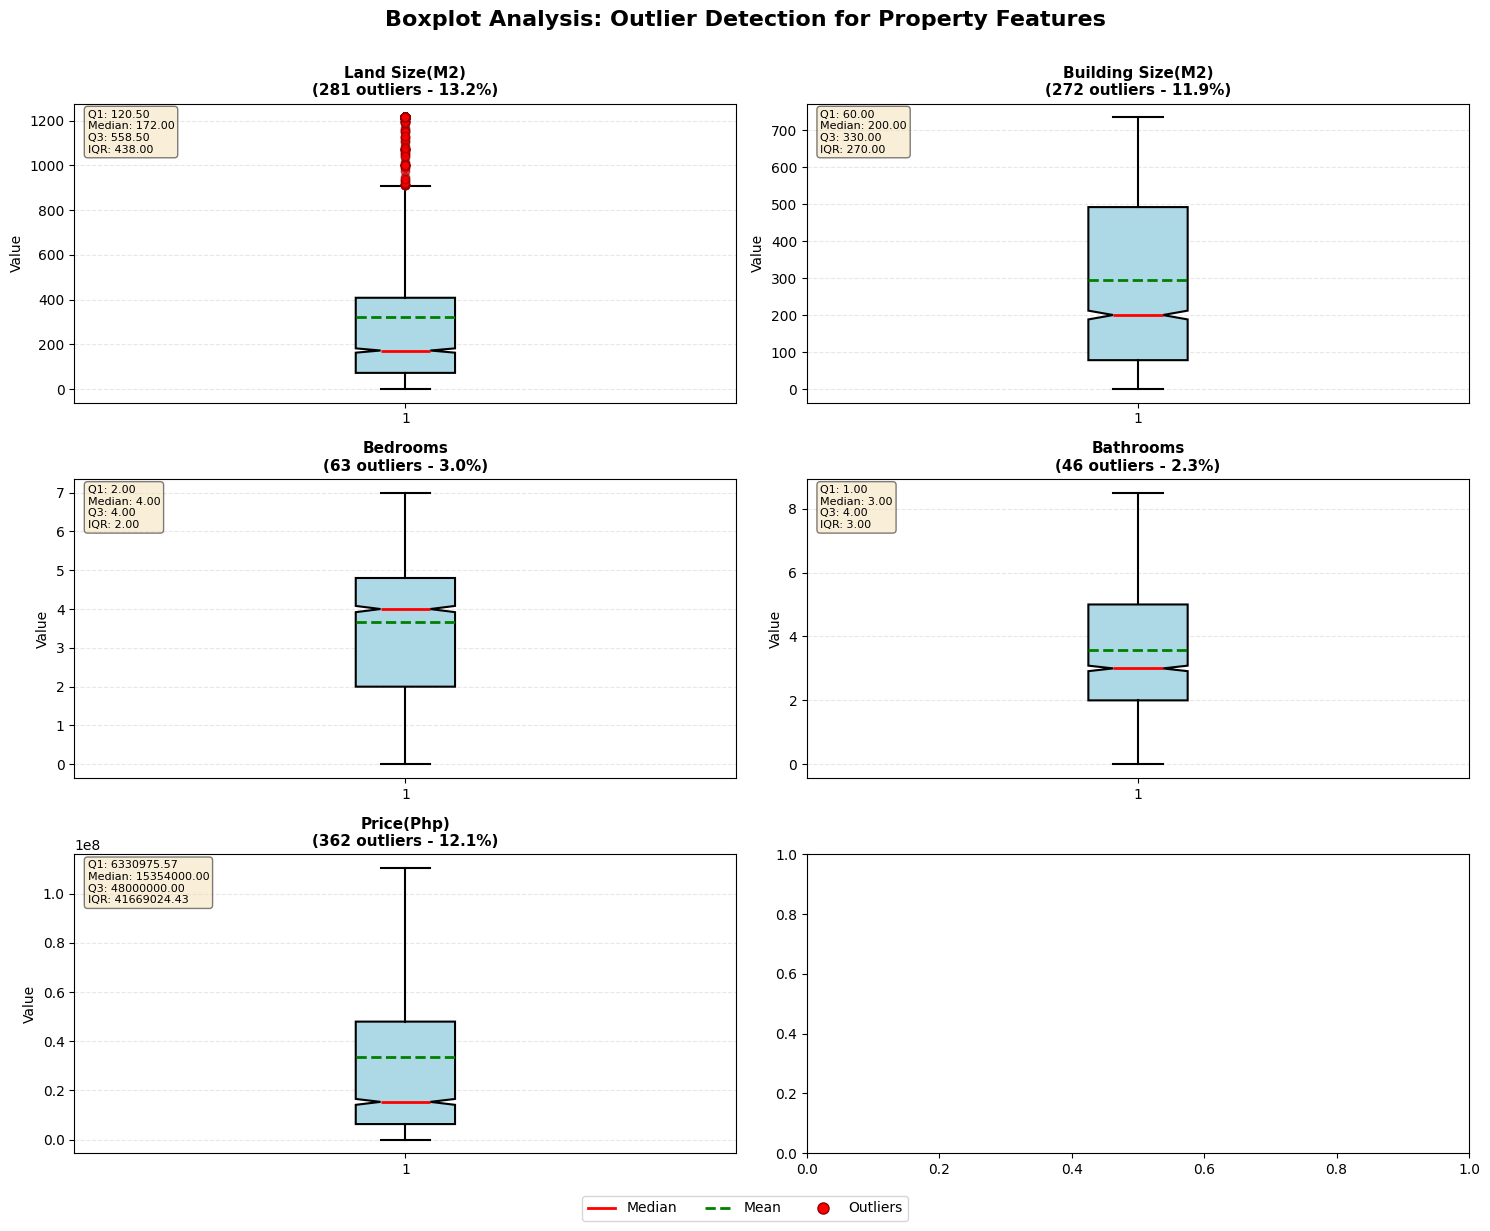

In [17]:
# Create boxplots to visualize outliers
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Boxplot Analysis: Outlier Detection for Property Features', 
             fontsize=16, fontweight='bold', y=0.995)

axes = axes.flatten()

for idx, col in enumerate(cols_to_check):
    ax = axes[idx]
    
    # Create boxplot
    bp = ax.boxplot(df[col].dropna(), 
                    vert=True, 
                    patch_artist=True,
                    notch=True,
                    showmeans=True,
                    meanline=True,
                    boxprops=dict(facecolor='lightblue', edgecolor='black', linewidth=1.5),
                    whiskerprops=dict(color='black', linewidth=1.5),
                    capprops=dict(color='black', linewidth=1.5),
                    medianprops=dict(color='red', linewidth=2),
                    meanprops=dict(color='green', linewidth=2, linestyle='--'),
                    flierprops=dict(marker='o', markerfacecolor='red', markersize=6, 
                                  alpha=0.6, markeredgecolor='darkred'))
    
    # Get outlier info for this column
    outlier_info = outlier_summary[outlier_summary['Column'] == col].iloc[0]
    
    # Add title with outlier count
    ax.set_title(f"{col}\n({int(outlier_info['Outlier Count'])} outliers - {outlier_info['Outlier %']:.1f}%)", 
                fontsize=11, fontweight='bold')
    ax.set_ylabel('Value', fontsize=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add text box with statistics
    stats_text = (f"Q1: {outlier_info['Q1']:.2f}\n"
                 f"Median: {df[col].median():.2f}\n"
                 f"Q3: {outlier_info['Q3']:.2f}\n"
                 f"IQR: {outlier_info['IQR']:.2f}")
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
           fontsize=8, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Add legend
legend_elements = [
    plt.Line2D([0], [0], color='red', linewidth=2, label='Median'),
    plt.Line2D([0], [0], color='green', linewidth=2, linestyle='--', label='Mean'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markersize=8, label='Outliers', markeredgecolor='darkred')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, 
          bbox_to_anchor=(0.5, -0.02), fontsize=10, frameon=True)

plt.tight_layout(rect=[0, 0.01, 1, 0.99])
#plt.savefig('outlier_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

Capping Outliers to ensure imputation reflects typical property values, outliers were capped before proceeding with KNN imputation.

In [12]:
# List of columns to cap
cols_to_cap = ['Price(Php)', 'Land Size(M2)', 'Building Size(M2)', 'Bedrooms', 'Bathrooms']

for col in cols_to_cap:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # --- Implement CAPPING (Winsorizing) ---
    # Cap values above the upper bound
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    
    # Cap values below the lower bound
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    
print("Outliers have been successfully capped in the DataFrame.")

Outliers have been successfully capped in the DataFrame.


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

# ... (Step 1: Capping code from previous response goes here) ...

# 1. Select the numerical columns that need imputation
impute_cols = ['Land Size(M2)', 'Building Size(M2)', 'Bedrooms', 'Bathrooms']
df_impute = df[impute_cols].copy()

# 2. Instantiate Scaler and Imputer
scaler = StandardScaler()
imputer = KNNImputer(n_neighbors=5) # K=5 is a common default

# 3. Scale the data (CRITICAL for KNN)
df_scaled = scaler.fit_transform(df_impute)

# 4. Apply KNN Imputation
df_imputed_scaled = imputer.fit_transform(df_scaled)

# 5. Inverse Transform back to original scale
df_imputed = scaler.inverse_transform(df_imputed_scaled)

# 6. Update the original DataFrame
df[impute_cols] = df_imputed

df.isnull().sum()

Location             0
Category             0
Sub-Category         0
Land Size(M2)        0
Building Size(M2)    0
Bedrooms             0
Bathrooms            0
Longitude            0
Latitude             0
Price(Php)           0
dtype: int64

KNN Imputation was used to preserve the complex, nonlinear relationships among real estate features.
By identifying similar property entries based on scaled distances, the model can infer realistic values for missing data.

### 3.4 Categorical Encoding
This process converts non-numeric, text-based categorical features (like 'Category', 'Location', 'Sub-Category') into a numerical format that machine learning algorithms can process.

In [14]:
# Display the first few rows of the DataFrame
df.head()

,Location,Category,Sub-Category,Land Size(M2),Building Size(M2),Bedrooms,Bathrooms,Longitude,Latitude,Price(Php)
0,"McKinley Hill, Taguig",Condominium,"Condominium,3-bedroom",84.3,128.0,3.0,2.0,121.055300,14.537120,19000000.0
1,"Sapang Maisac, Mexico",House,"House,single-family-house",101.0,60.0,3.0,2.0,120.665111,15.169115,3700000.0
2,"Catalunan Grande, Davao",House,"House,single-family-house",100.0,75.0,3.0,2.0,125.534347,7.090939,3790000.0
3,"Margaay, Narvacan",Land,"Land,agricutural-lot",1215.5,728.0,7.0,7.2,120.470266,17.430680,3066000.0
4,"Laiya-Aplaya, San Juan",Land,"Land,beach-lot",537.0,386.0,4.4,4.6,121.379905,13.691466,20191200.0


One hot encoding Category and Sub-Category

In [19]:
# 1. Inspect unique values (optional, but good practice)
print("Unique Categories:", df['Category'].unique())
print("Unique Sub-Categories:", df['Sub-Category'].unique())

Unique Categories: ['Condominium' 'House' 'Land' 'Commercial' 'Apartment']
Unique Sub-Categories: ['Condominium,3-bedroom' 'House,single-family-house'
 'Land,agricutural-lot' 'Land,beach-lot' 'Land,residential-lot'
 'Condominium,double-bedroom' 'Condominium,dormitory' 'House,villas'
 'House,townhouse' 'Land,commercial-lot' 'Condominium,loft-1'
 'Condominium,single-bedroom' 'Condominium,studio' 'Commercial,retail'
 'Land,memorial-lot' 'Commercial,building' 'Commercial,warehouse'
 'Commercial,offices' 'Condominium,4-bedroom' 'Condominium,penthouse-1'
 'Apartment,apartments' 'Condominium,other-4' 'Apartment,loft'
 'Apartment,room-1' 'House,beach-house' 'Commercial,coworking'
 'Commercial,serviced-office']


In [20]:
# List of the columns you want to encode
cols_to_encode = ['Category', 'Sub-Category']

# Apply One-Hot Encoding
df = pd.get_dummies(df, columns=cols_to_encode, drop_first=True)

# The original columns are now replaced by the new binary columns.
print("One-Hot Encoding complete.")
print("New columns created:")
print([col for col in df.columns if 'Category_' in col or 'Sub-Category_' in col])
print("\nFirst 5 rows of the updated DataFrame:")
print(df.head())

One-Hot Encoding complete.
New columns created:
['Category_Commercial', 'Category_Condominium', 'Category_House', 'Category_Land', 'Sub-Category_Apartment,loft', 'Sub-Category_Apartment,room-1', 'Sub-Category_Commercial,building', 'Sub-Category_Commercial,coworking', 'Sub-Category_Commercial,offices', 'Sub-Category_Commercial,retail', 'Sub-Category_Commercial,serviced-office', 'Sub-Category_Commercial,warehouse', 'Sub-Category_Condominium,3-bedroom', 'Sub-Category_Condominium,4-bedroom', 'Sub-Category_Condominium,dormitory', 'Sub-Category_Condominium,double-bedroom', 'Sub-Category_Condominium,loft-1', 'Sub-Category_Condominium,other-4', 'Sub-Category_Condominium,penthouse-1', 'Sub-Category_Condominium,single-bedroom', 'Sub-Category_Condominium,studio', 'Sub-Category_House,beach-house', 'Sub-Category_House,single-family-house', 'Sub-Category_House,townhouse', 'Sub-Category_House,villas', 'Sub-Category_Land,agricutural-lot', 'Sub-Category_Land,beach-lot', 'Sub-Category_Land,commercial-lo

### 3.4.1 Location Clustering

To handle the high cardinality of the Location column, a clustering approach was applied using the property’s geographic coordinates — Longitude and Latitude. Instead of encoding hundreds of unique location names, K-Means Clustering groups properties into a smaller number of location clusters based on their proximity on the map.

This means that properties located near each other (e.g., within the same city or region) are assigned to the same cluster.
By doing this, the model captures geographical influence on property prices — since properties in the same area often share similar market conditions, accessibility, and neighborhood characteristics.

The resulting Location_Cluster feature provides a numerical representation of geographic regions that the Random Forest Regression model can effectively use to improve prediction accuracy.

In [15]:
from sklearn.cluster import KMeans

# Drop 'Location' if Longitude/Latitude are present
df = df.drop('Location', axis=1)

# Cluster by geographic proximity
kmeans = KMeans(n_clusters=10, random_state=42)
df['Location_Cluster'] = kmeans.fit_predict(df[['Longitude', 'Latitude']])

df.head()

,Category,Sub-Category,Land Size(M2),Building Size(M2),Bedrooms,Bathrooms,Longitude,Latitude,Price(Php),Location_Cluster
0,Condominium,"Condominium,3-bedroom",84.3,128.0,3.0,2.0,121.055300,14.537120,19000000.0,0
1,House,"House,single-family-house",101.0,60.0,3.0,2.0,120.665111,15.169115,3700000.0,7
2,House,"House,single-family-house",100.0,75.0,3.0,2.0,125.534347,7.090939,3790000.0,3
3,Land,"Land,agricutural-lot",1215.5,728.0,7.0,7.2,120.470266,17.430680,3066000.0,5
4,Land,"Land,beach-lot",537.0,386.0,4.4,4.6,121.379905,13.691466,20191200.0,0


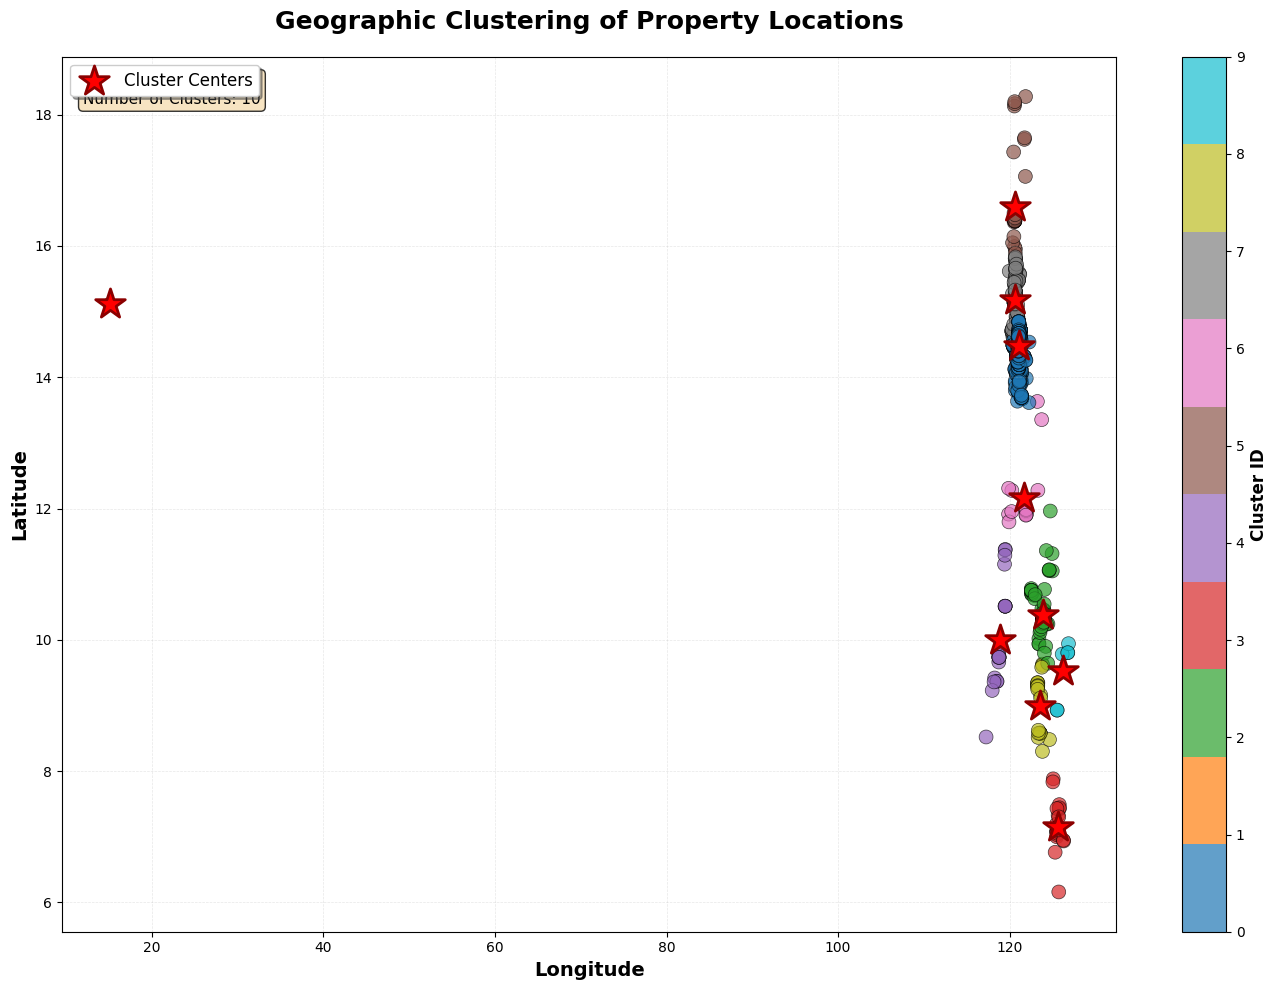


=== Cluster Statistics ===
Total properties analyzed: 3000

Properties per cluster:
  Cluster 0: 2553 properties (85.1%)
  Cluster 1: 1 properties (0.0%)
  Cluster 2: 149 properties (5.0%)
  Cluster 3: 32 properties (1.1%)
  Cluster 4: 23 properties (0.8%)
  Cluster 5: 51 properties (1.7%)
  Cluster 6: 19 properties (0.6%)
  Cluster 7: 143 properties (4.8%)
  Cluster 8: 23 properties (0.8%)
  Cluster 9: 6 properties (0.2%)

Cluster Centers (Longitude, Latitude):
  Cluster 0: (121.04, 14.47)
  Cluster 1: (15.11, 15.11)
  Cluster 2: (123.84, 10.37)
  Cluster 3: (125.61, 7.16)
  Cluster 4: (118.84, 10.00)
  Cluster 5: (120.68, 16.59)
  Cluster 6: (121.66, 12.16)
  Cluster 7: (120.64, 15.17)
  Cluster 8: (123.53, 9.00)
  Cluster 9: (126.27, 9.53)


In [18]:

# Create a larger, higher quality figure
plt.figure(figsize=(14, 10))

# Enhanced scatter plot with better styling
scatter = plt.scatter(df['Longitude'], df['Latitude'], 
                     c=df['Location_Cluster'], 
                     cmap='tab10',  # Better color palette for distinct clusters
                     s=100,  # Larger points
                     alpha=0.7,  # Slight transparency
                     edgecolors='black',  # Black borders for better visibility
                     linewidth=0.5)

# Plot cluster centers with enhanced styling
plt.scatter(kmeans.cluster_centers_[:, 0], 
           kmeans.cluster_centers_[:, 1], 
           c='red', 
           s=500,  # Larger centers
           marker='*',  # Star marker for centers
           edgecolors='darkred',
           linewidth=2,
           label='Cluster Centers',
           zorder=5)  # Ensure centers appear on top

# Enhanced title and labels
plt.title('Geographic Clustering of Property Locations', 
         fontsize=18, 
         fontweight='bold',
         pad=20)
plt.xlabel('Longitude', fontsize=14, fontweight='bold')
plt.ylabel('Latitude', fontsize=14, fontweight='bold')

# Add colorbar to show cluster assignments
cbar = plt.colorbar(scatter, label='Cluster ID')
cbar.set_label('Cluster ID', fontsize=12, fontweight='bold')

# Enhanced legend
plt.legend(fontsize=12, 
          loc='upper left',
          frameon=True,
          shadow=True,
          fancybox=True)

# Improved grid
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Add cluster statistics as text annotation
n_clusters = len(kmeans.cluster_centers_)
cluster_counts = df['Location_Cluster'].value_counts().sort_index()

stats_text = f"Total Properties: {len(df)}\nNumber of Clusters: {n_clusters}"
plt.text(0.02, 0.98, stats_text,
        transform=plt.gca().transAxes,
        fontsize=11,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

# Optional: Print cluster statistics
print("\n=== Cluster Statistics ===")
print(f"Total properties analyzed: {len(df)}")
print(f"\nProperties per cluster:")
for cluster_id in sorted(df['Location_Cluster'].unique()):
    count = len(df[df['Location_Cluster'] == cluster_id])
    percentage = (count / len(df)) * 100
    print(f"  Cluster {cluster_id}: {count} properties ({percentage:.1f}%)")

print(f"\nCluster Centers (Longitude, Latitude):")
for i, center in enumerate(kmeans.cluster_centers_):
    print(f"  Cluster {i}: ({center[0]:.2f}, {center[1]:.2f})")